In [1]:
# importing necessary libraries
import numpy as np
import yfinance as yf  # This library is for fetching stock data from yahoo finance
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.regularizers import l2
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
# Fetch historical stock data using yfinance
stock_symbol = 'IBM'
start_date = '2012-01-01'
end_date = '2023-01-01'
stock_data = yf.download(stock_symbol, start=start_date, end=end_date, progress=False)
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,178.518158,180.411087,177.820267,178.107071,114.206619,5905716
2012-01-04,177.409180,178.135757,176.806885,177.380493,113.740669,4546648
2012-01-05,176.682602,176.892929,175.047806,176.539200,113.201248,4668403
2012-01-06,176.281067,176.367111,174.292542,174.512421,111.901596,5122367
2012-01-09,174.187378,174.254303,172.342255,173.604202,111.319244,5440455
...,...,...,...,...,...,...
2022-12-23,140.589996,141.860001,139.600006,141.649994,136.478256,2092500
2022-12-27,141.729996,142.720001,141.229996,142.419998,137.220139,2742400
2022-12-28,142.399994,142.809998,139.949997,140.020004,134.907776,2539500


In [3]:
# Extract adjusted closing prices
prices = stock_data['Adj Close'].values
prices

array([114.20661926, 113.74066925, 113.20124817, ..., 134.90777588,
       135.90979004, 135.7460022 ])

In [4]:
# Calculate RSI indicator
rsi_period = 14
delta = np.diff(prices)
gain = np.where(delta > 0, delta, 0)
loss = np.where(delta < 0, -delta, 0)
average_gain = np.mean(gain[:rsi_period])
average_loss = np.mean(loss[:rsi_period])
rsi_values = np.zeros_like(prices)
rsi_values[:rsi_period] = 100.0 - (100.0 / (1.0 + (average_gain / average_loss)))

for i in range(rsi_period, len(prices)):
    average_gain = (average_gain * (rsi_period - 1) + gain[i - 1]) / rsi_period
    average_loss = (average_loss * (rsi_period - 1) + loss[i - 1]) / rsi_period
    rsi_values[i] = 100.0 - (100.0 / (1.0 + (average_gain / average_loss)))

In [5]:
# Calculate EMA indicators
emaf_period = 12
emaf_values = np.convolve(prices, np.ones(emaf_period)/emaf_period, mode='valid')
emam_period = 26
emam_values = np.convolve(prices, np.ones(emam_period)/emam_period, mode='valid')
emas_period = 50
emas_values = np.convolve(prices, np.ones(emas_period)/emas_period, mode='valid')

In [6]:
# Normalize the data using Min-Max scaling
scaler = MinMaxScaler()
prices_scaled = scaler.fit_transform(prices.reshape(-1, 1))
rsi_scaled = scaler.fit_transform(rsi_values.reshape(-1, 1))
emaf_scaled = scaler.fit_transform(emaf_values.reshape(-1, 1))
emam_scaled = scaler.fit_transform(emam_values.reshape(-1, 1))
emas_scaled = scaler.fit_transform(emas_values.reshape(-1, 1))

In [7]:
# Ensure that all indicator arrays have the same length
common_length = min(len(prices_scaled), len(rsi_scaled), len(emaf_scaled), len(emam_scaled), len(emas_scaled))
prices_scaled = prices_scaled[:common_length]
rsi_scaled = rsi_scaled[:common_length]
emaf_scaled = emaf_scaled[:common_length]
emam_scaled = emam_scaled[:common_length]
emas_scaled = emas_scaled[:common_length]

In [8]:
# Create sequences and labels
sequence_length = 30
X = np.column_stack((prices_scaled, rsi_scaled, emaf_scaled, emam_scaled, emas_scaled))
y = prices_scaled[sequence_length:]
X = [X[i:i + sequence_length] for i in range(len(X) - sequence_length)]
y = [y[i + sequence_length] for i in range(len(y) - sequence_length)]

X = np.array(X)
y = np.array(y)

In [9]:
# Ensure that X and y have the same length
common_length = min(len(X), len(y))
X = X[:common_length]
y = y[:common_length]

In [10]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [11]:
# Define the input shape
input_shape = (sequence_length, 5)
input_layer = layers.Input(shape=input_shape, name='Input')

# GRU Layer 1
gru_1 = layers.GRU(units=50, return_sequences=True, activation='tanh', kernel_regularizer=l2(0.01), dropout=0.2, recurrent_dropout=0.1)(input_layer)

# LSTM Layer
lstm_input = layers.Reshape((1, -1))(gru_1)
lstm_1 = layers.LSTM(units= 50, activation='tanh')(lstm_input)

# Output Layer
output_layer = layers.Dense(1, activation='linear')(lstm_1)

# Create the model
gru_model = models.Model(inputs=input_layer, outputs=output_layer, name='GRU_Model')
gru_model.summary()


Model: "GRU_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 30, 5)]           0         
                                                                 
 gru (GRU)                   (None, 30, 50)            8550      
                                                                 
 reshape (Reshape)           (None, 1, 1500)           0         
                                                                 
 lstm (LSTM)                 (None, 50)                310200    
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 318,801
Trainable params: 318,801
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Compile model
gru_model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.001), metrics=['mae', 'mse'])

In [13]:
# Train model

history = gru_model.fit(x=X_train, y=y_train,
                         batch_size=64, epochs=50, validation_data=(X_test, y_test),
                         shuffle=True,validation_split = 0.1)

print(history.history.keys)

Epoch 1/50
30/30 [==============================] - 14s 127ms/step - loss: 0.1198 - mae: 0.1418 - mse: 0.0365 - val_loss: 0.0812 - val_mae: 0.0883 - val_mse: 0.0118
Epoch 2/50
30/30 [==============================] - 4s 152ms/step - loss: 0.0680 - mae: 0.0684 - mse: 0.0083 - val_loss: 0.0560 - val_mae: 0.0572 - val_mse: 0.0059
Epoch 3/50
30/30 [==============================] - 3s 113ms/step - loss: 0.0501 - mae: 0.0614 - mse: 0.0067 - val_loss: 0.0415 - val_mae: 0.0514 - val_mse: 0.0047
Epoch 4/50
30/30 [==============================] - 3s 108ms/step - loss: 0.0385 - mae: 0.0597 - mse: 0.0063 - val_loss: 0.0320 - val_mae: 0.0527 - val_mse: 0.0045
Epoch 5/50
30/30 [==============================] - 3s 107ms/step - loss: 0.0300 - mae: 0.0578 - mse: 0.0057 - val_loss: 0.0247 - val_mae: 0.0477 - val_mse: 0.0038
Epoch 6/50
30/30 [==============================] - 4s 140ms/step - loss: 0.0238 - mae: 0.0548 - mse: 0.0052 - val_loss: 0.0199 - val_mae: 0.0453 - val_mse: 0.0037
Epoch 7/50
30/3

In [14]:
# Evaluate the model
loss = gru_model.evaluate(X_test, y_test, verbose=0)[0]  # Extract the loss value from the list
y_pred = gru_model.predict(X_test)
mae = np.mean(np.abs(y_pred - y_test))  # Calculate MAE manually

print(f"Test loss: {loss:.4f}, Test MAE: {mae:.4f}")

25/25 [==============================] - 1s 11ms/step
Test loss: 0.0039, Test MAE: 0.0452


In [15]:
# Prediction on test set
y_pred = gru_model.predict(X_test)

25/25 [==============================] - 0s 11ms/step


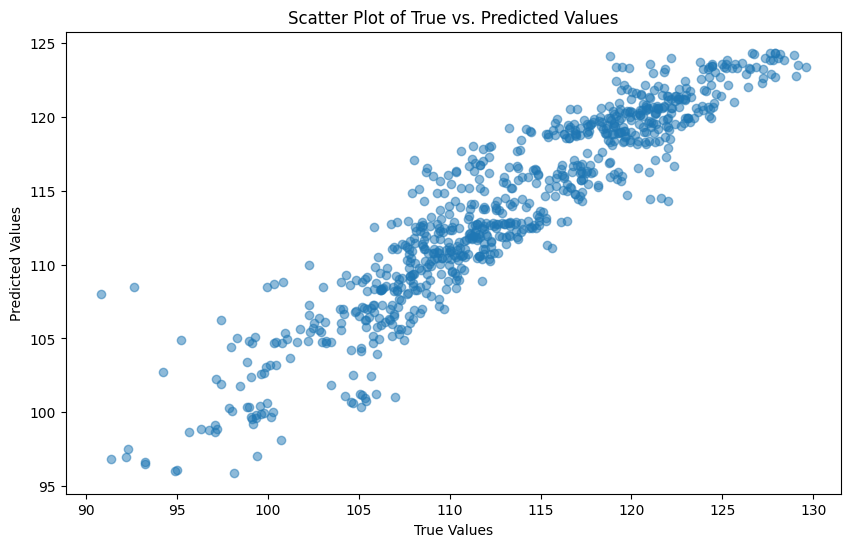

In [16]:
# Inverse scale the predictions and true values
y_pred_original = scaler.inverse_transform(y_pred)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, y_pred_original, alpha=0.5)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot of True vs. Predicted Values')
plt.show()

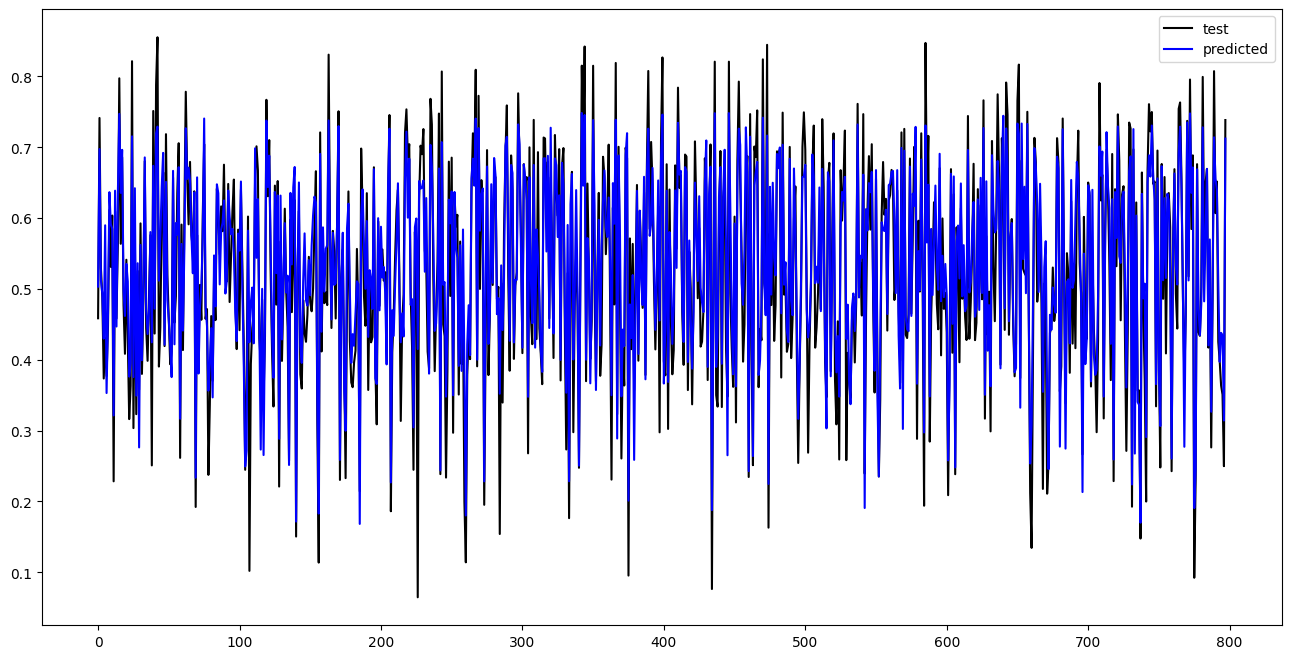

In [17]:
# Line plot prediction graph

plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'black',label='test')
plt.plot(y_pred, color = 'blue',label='predicted')
plt.legend()
plt.show()

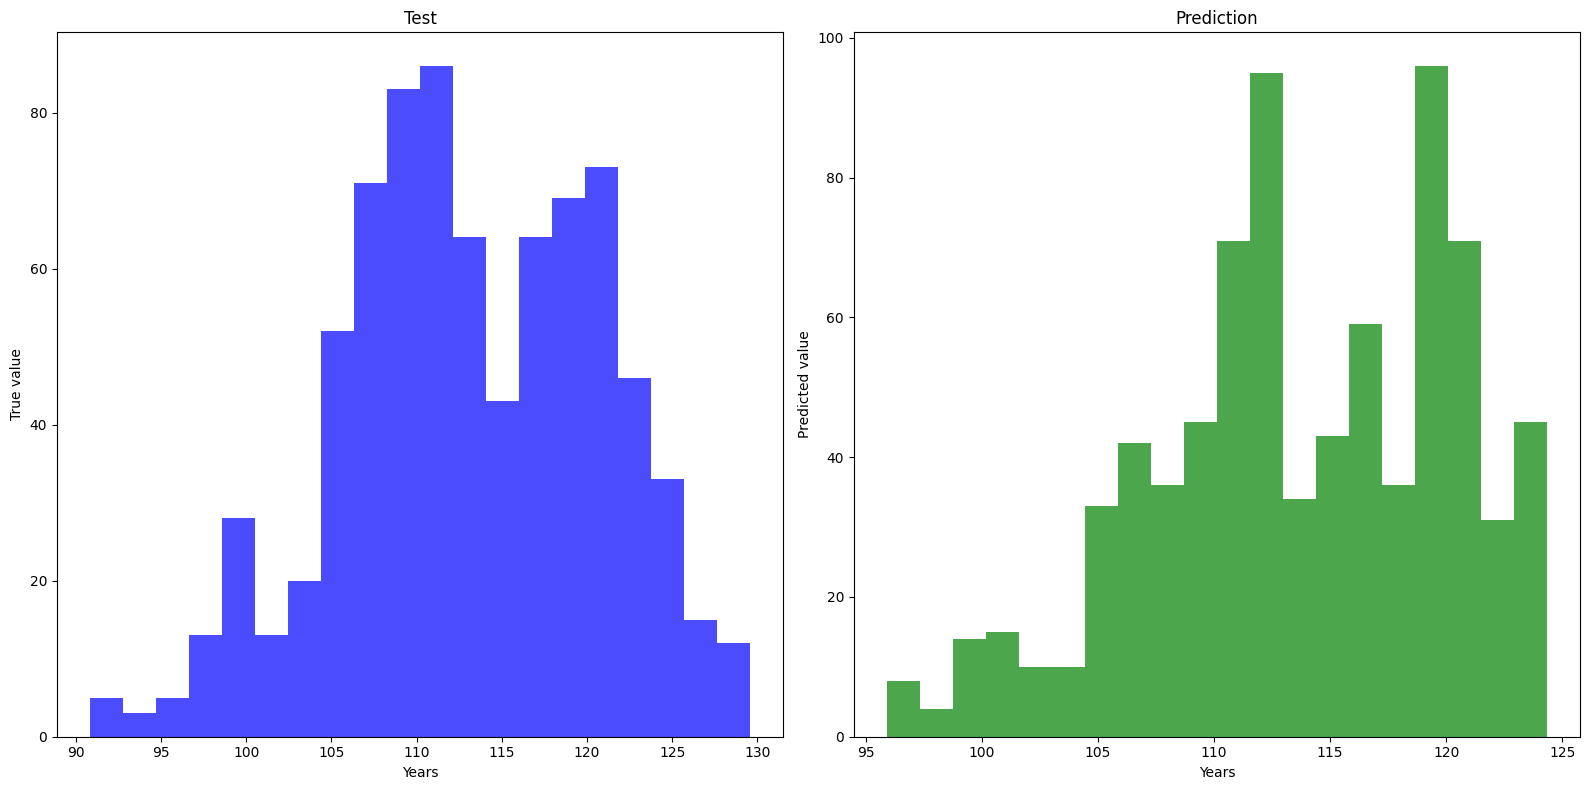

In [18]:
# Create subplots with histograms
fig, axs = plt.subplots(1, 2, figsize=(16, 8))  # 1 row, 2 columns

# Subplot 1
axs[0].hist(y_test_original, bins=20, color='blue', alpha=0.7)
axs[0].set_xlabel('Years')
axs[0].set_ylabel('True value')
axs[0].set_title('Test')

# Subplot 2
axs[1].hist(y_pred_original, bins=20, color='green', alpha=0.7)
axs[1].set_xlabel('Years')
axs[1].set_ylabel('Predicted value')
axs[1].set_title('Prediction')

# Adjust layout
plt.tight_layout()
plt.show()

In [19]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate R-squared (R2) score
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R2) score: {r2:.4f}")

Mean Absolute Error (MAE): 0.0452
Mean Squared Error (MSE): 0.0035
Root Mean Squared Error (RMSE): 0.0590
R-squared (R2) score: 0.8545


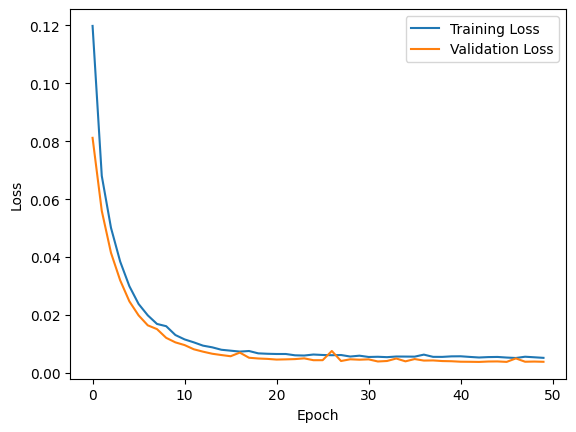

In [20]:
# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

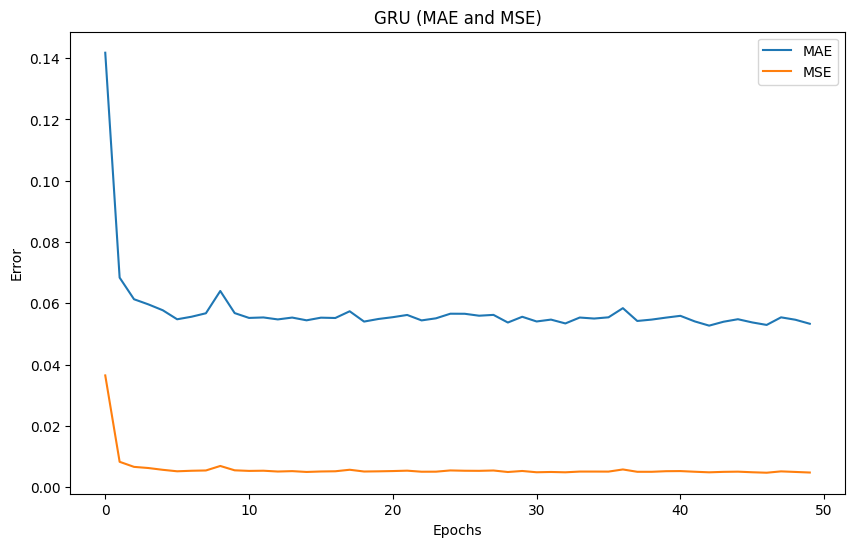

In [21]:
# Line plot over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['mae'], label='MAE')
plt.plot(history.history['mse'], label='MSE')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('GRU (MAE and MSE)')
plt.legend()
plt.show()